<a href="https://colab.research.google.com/github/Balakumar6075/Fake-news-detector/blob/main/Copy_of_b2_FakeNewDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment

In [ ]:
# Install specific libraries
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 117.0 MB/s eta 0:00:00
   ━━

In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set Working Directory - if working on Google Drive
%cd /content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection

# # Set Working Directory - if working on Local Machine
# import os
# os.chdir('/Users//replace_me')

[Errno 2] No such file or directory: '/content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection'
/content


## Load Dataset

In [16]:
# Load Dataset
true_data = pd.read_csv('/content/drive/MyDrive/Fake news detector/true.csv')
fake_data = pd.read_csv('/content/drive/MyDrive/Fake news detector/fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
# data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index']) # Original line with error
data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index().drop(columns=['index']) # Changed line using pd.concat
# See how the data looks like
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,Effort to replace Trump on ballot would face t...,WASHINGTON (Reuters) - Some prominent Republic...,politicsNews,"October 9, 2016",True
1,"The NRA Endorsed Trump, But They’d Have Ended...","Donald Trump gave a speech to the NRA, who the...",News,"May 20, 2016",Fake
2,HILLARY APPEARS Wearing “Anti-Seizure” Sunglas...,Remember when experts came out after Hillary c...,left-news,"May 30, 2017",Fake
3,LEFTIST BULLY ARTISTS Tell Ivanka Trump: “Get ...,A growing group of artists is hitting back aga...,left-news,"Dec 22, 2016",Fake
4,LYNCH MOB WINS By Less Than 1%…Why Republicans...,They threw everything but the kitchen sink at ...,left-news,"Dec 12, 2017",Fake


In [17]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target)['Fake']

In [18]:
data.head()

,title,text,subject,date,Target,label
0,Effort to replace Trump on ballot would face t...,WASHINGTON (Reuters) - Some prominent Republic...,politicsNews,"October 9, 2016",True,False
1,"The NRA Endorsed Trump, But They’d Have Ended...","Donald Trump gave a speech to the NRA, who the...",News,"May 20, 2016",Fake,True
2,HILLARY APPEARS Wearing “Anti-Seizure” Sunglas...,Remember when experts came out after Hillary c...,left-news,"May 30, 2017",Fake,True
3,LEFTIST BULLY ARTISTS Tell Ivanka Trump: “Get ...,A growing group of artists is hitting back aga...,left-news,"Dec 22, 2016",Fake,True
4,LYNCH MOB WINS By Less Than 1%…Why Republicans...,They threw everything but the kitchen sink at ...,left-news,"Dec 12, 2017",Fake,True


([<matplotlib.patches.Wedge at 0x7f918b14d690>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

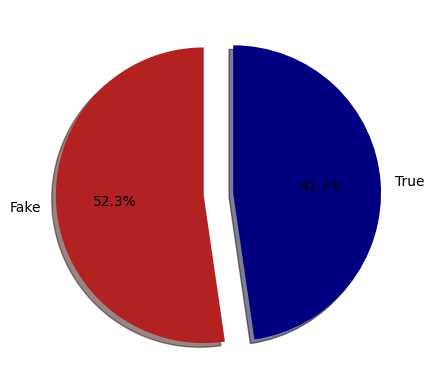

In [19]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Train-test-split

In [20]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [32]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Prepare Input Data

Text(0, 0.5, 'Number of texts')

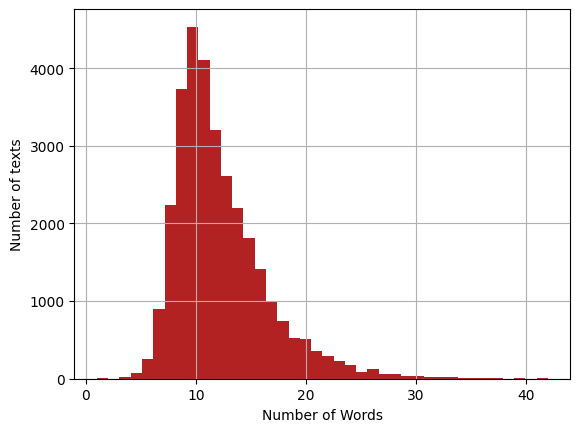

In [33]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [23]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.",
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [24]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [25]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [26]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

### Freeze Layers

In [27]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [28]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

### Define Train & Evaluate Function

In [29]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

### Model training

In [35]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist(), dtype=torch.long) # Change to long

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist(), dtype=torch.long) # Change to long


test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist(), dtype=torch.long) # Change to long

### Model performance

In [41]:
# load weights of best model
import os
import torch

path = '/content/drive/MyDrive/Fake news detector/1wei.pt'  # Specify the correct path
print(os.path.exists(path))  # Check file existence



True


In [44]:
# load weights of best model
import os
import torch

path = '/content/drive/MyDrive/Fake news detector/1wei.pt'  # Specify the correct path
print(os.path.exists(path))  # Check file existence

# Move the model to the device
model.to(device)  # Add this line

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))  # Move inputs to device
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y.cpu().numpy(), preds))  # Move test_y to CPU and convert to numpy

True
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3212
           1       0.88      0.87      0.87      3523

    accuracy                           0.87      6735
   macro avg       0.87      0.87      0.87      6735
weighted avg       0.87      0.87      0.87      6735



## Fake News Predictions

In [45]:
# # load weights of best model
# path = 'c1_fakenews_weights.pt'
# model.load_state_dict(torch.load(path))

In [48]:
def predict_news():
  """Predicts the authenticity of news headlines provided by the user."""
  # Get user input
  news_text = input("Enter the news headline (or type 'exit' to quit): ")
  if news_text.lower() == 'exit':
    return "Exiting..."

  # Tokenize and encode
  MAX_LENGHT = 15
  tokens_unseen = tokenizer.batch_encode_plus(
      [news_text],  # Wrap input in a list for batch processing
      max_length=MAX_LENGHT,
      pad_to_max_length=True,
      truncation=True
  )
  unseen_seq = torch.tensor(tokens_unseen['input_ids']).to(device) # Move to device
  unseen_mask = torch.tensor(tokens_unseen['attention_mask']).to(device) # Move to device

  # Make prediction
  with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    preds = preds.detach().cpu().numpy()

  prediction = np.argmax(preds, axis=1)[0]  # Get the prediction (0 or 1)

  # Return result
  return "The provided news is likely " + ("fake" if prediction == 1 else "true") + "."

# Main loop with switch case
while True:
  print("\nChoose an action:")
  print("1. Predict news authenticity")
  print("2. Exit")

  choice = input("Enter your choice: ")

  if choice == '1':
    result = predict_news()
    print(result)
  elif choice == '2':
    print("Exiting...")
    break
  else:
    print("Invalid choice. Please try again.")


Choose an action:
1. Predict news authenticity
2. Exit
Enter your choice: 1
Enter the news headline (or type 'exit' to quit): White House, Congress prepare for talks on spending, immigration
The provided news is likely true.

Choose an action:
1. Predict news authenticity
2. Exit
Enter your choice: 1
Enter the news headline (or type 'exit' to quit): Drunk Bragging Trump Staffer Started Russian Collusion Investigation
The provided news is likely fake.

Choose an action:
1. Predict news authenticity
2. Exit
Enter your choice: 2
Exiting...
